train Assignment 2 Bijayan Ray

In [1]:
import mlflow

ModuleNotFoundError: No module named 'mlflow'

In [36]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Load preprocessed train, validation, and test datasets
train_data = pd.read_csv('train.csv')
validation_data = pd.read_csv('validation.csv')
test_data = pd.read_csv('test.csv')

# Combine train and validation data for fine-tuning hyperparameters
train_validation_data = pd.concat([train_data, validation_data])

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = vectorizer.fit_transform(train_data['message'])
X_validation = vectorizer.transform(validation_data['message'])
X_train_validation = vectorizer.transform(train_validation_data['message'])
X_test = vectorizer.transform(test_data['message'])

# Map labels to "spam" and "not spam"
train_data['label'] = train_data['label'].map({0: "not spam", 1: "spam"})
validation_data['label'] = validation_data['label'].map({0: "not spam", 1: "spam"})
test_data['label'] = test_data['label'].map({0: "not spam", 1: "spam"})
train_validation_data['label'] = train_validation_data['label'].map({0: "not spam", 1: "spam"})

y_train = train_data['label']
y_validation = validation_data['label']
y_train_validation = train_validation_data['label']
y_test = test_data['label']

# Function to fit, score, evaluate, and plot confusion matrix for a model
def evaluate_model(model, X_train, y_train, X_validation, y_validation, model_name):
    # Fit the model
    model.fit(X_train, y_train)

    # Score the model
    train_accuracy = model.score(X_train, y_train)
    validation_accuracy = model.score(X_validation, y_validation)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_validation_pred = model.predict(X_validation)

    # Print accuracy and classification report
    print(f"{model_name} Train Accuracy: {train_accuracy:.4f}")
    print(f"{model_name} Validation Accuracy: {validation_accuracy:.4f}")
    print("Train Classification Report:\n", classification_report(y_train, y_train_pred, target_names=["not spam", "spam"]))
    print("Validation Classification Report:\n", classification_report(y_validation, y_validation_pred, target_names=["not spam", "spam"]))

    # Plot confusion matrix
    print(f"{model_name} Confusion Matrix for Validation Data:")
    cm = confusion_matrix(y_validation, y_validation_pred, labels=["not spam", "spam"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not spam", "spam"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix (Validation)")
    plt.show()

    return model

Logistic Regression Evaluation
Logistic Regression Train Accuracy: 0.9718
Logistic Regression Validation Accuracy: 0.9629
Train Classification Report:
               precision    recall  f1-score   support

    not spam       0.97      1.00      0.98      3377
        spam       0.99      0.80      0.88       523

    accuracy                           0.97      3900
   macro avg       0.98      0.90      0.93      3900
weighted avg       0.97      0.97      0.97      3900

Validation Classification Report:
               precision    recall  f1-score   support

    not spam       0.96      1.00      0.98       724
        spam       1.00      0.72      0.84       112

    accuracy                           0.96       836
   macro avg       0.98      0.86      0.91       836
weighted avg       0.96      0.96      0.96       836

Logistic Regression Confusion Matrix for Validation Data:


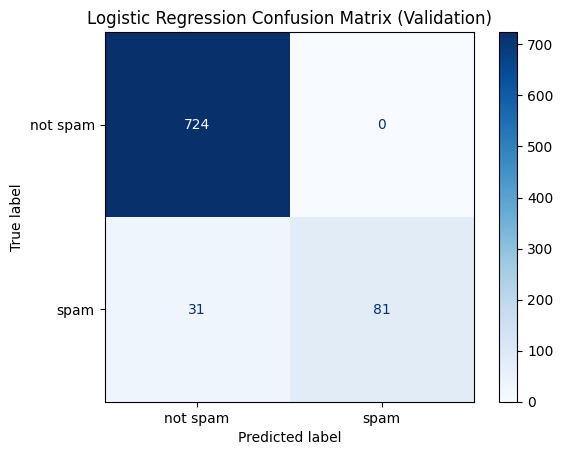

In [37]:
print("Logistic Regression Evaluation")
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model = evaluate_model(logistic_model, X_train, y_train, X_validation, y_validation, "Logistic Regression")

Multinomial Naive Bayes Evaluation
Multinomial Naive Bayes Train Accuracy: 0.9851
Multinomial Naive Bayes Validation Accuracy: 0.9689
Train Classification Report:
               precision    recall  f1-score   support

    not spam       0.98      1.00      0.99      3377
        spam       1.00      0.89      0.94       523

    accuracy                           0.99      3900
   macro avg       0.99      0.94      0.97      3900
weighted avg       0.99      0.99      0.98      3900

Validation Classification Report:
               precision    recall  f1-score   support

    not spam       0.97      1.00      0.98       724
        spam       1.00      0.77      0.87       112

    accuracy                           0.97       836
   macro avg       0.98      0.88      0.93       836
weighted avg       0.97      0.97      0.97       836

Multinomial Naive Bayes Confusion Matrix for Validation Data:


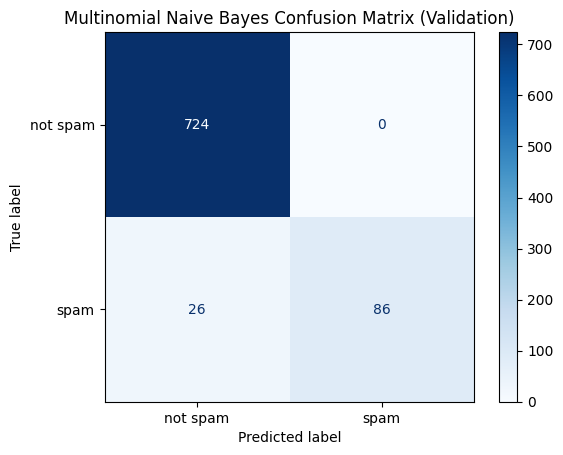

In [38]:
print("Multinomial Naive Bayes Evaluation")
nb_model = MultinomialNB()
nb_model = evaluate_model(nb_model, X_train, y_train, X_validation, y_validation, "Multinomial Naive Bayes")


Support Vector Machine Evaluation
Support Vector Machine Train Accuracy: 0.9956
Support Vector Machine Validation Accuracy: 0.9844
Train Classification Report:
               precision    recall  f1-score   support

    not spam       1.00      1.00      1.00      3377
        spam       1.00      0.97      0.98       523

    accuracy                           1.00      3900
   macro avg       1.00      0.99      0.99      3900
weighted avg       1.00      1.00      1.00      3900

Validation Classification Report:
               precision    recall  f1-score   support

    not spam       0.98      1.00      0.99       724
        spam       0.99      0.89      0.94       112

    accuracy                           0.98       836
   macro avg       0.99      0.95      0.97       836
weighted avg       0.98      0.98      0.98       836

Support Vector Machine Confusion Matrix for Validation Data:


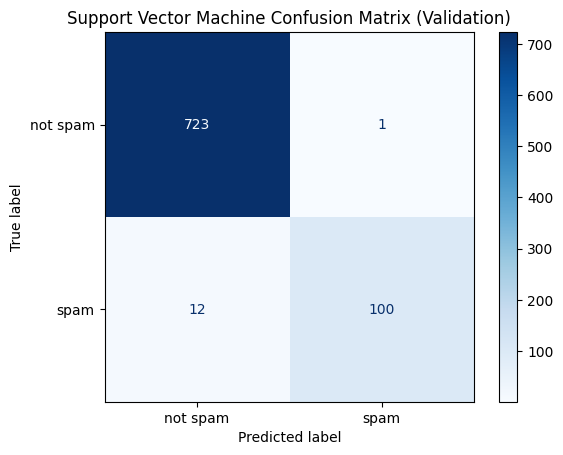

In [39]:
print("Support Vector Machine Evaluation")
svm_model = SVC(kernel='linear', random_state=42)
svm_model = evaluate_model(svm_model, X_train, y_train, X_validation, y_validation, "Support Vector Machine")


In [40]:
print("Fine-tuning Logistic Regression")
param_grid = {'C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_validation, y_train_validation)

# Best hyperparameters
best_logistic_model = grid_search.best_estimator_
print("Best Hyperparameters for Logistic Regression:", grid_search.best_params_)


Fine-tuning Logistic Regression
Best Hyperparameters for Logistic Regression: {'C': 100}


Evaluating Best Model (Logistic Regression) on Test Data
Best Logistic Regression Test Accuracy: 0.9868
Test Classification Report:
               precision    recall  f1-score   support

    not spam       0.99      1.00      0.99       724
        spam       0.99      0.91      0.95       112

    accuracy                           0.99       836
   macro avg       0.99      0.95      0.97       836
weighted avg       0.99      0.99      0.99       836

Best Logistic Regression Confusion Matrix for Test Data:


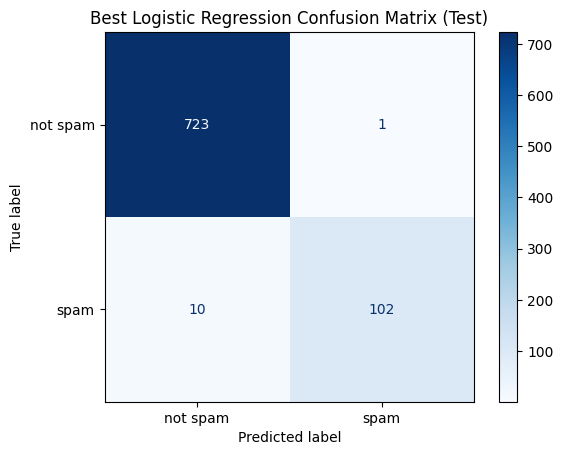

In [41]:
print("Evaluating Best Model (Logistic Regression) on Test Data")
best_logistic_model.fit(X_train_validation, y_train_validation)
y_test_pred = best_logistic_model.predict(X_test)

# Test evaluation
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Best Logistic Regression Test Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:\n", classification_report(y_test, y_test_pred, target_names=["not spam", "spam"]))

print("Best Logistic Regression Confusion Matrix for Test Data:")
cm = confusion_matrix(y_test, y_test_pred, labels=["not spam", "spam"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not spam", "spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Best Logistic Regression Confusion Matrix (Test)")
plt.show()


Benchmarking Models on Test Data
Logistic Regression Test Accuracy: 0.9677
Logistic Regression Confusion Matrix for Test Data:


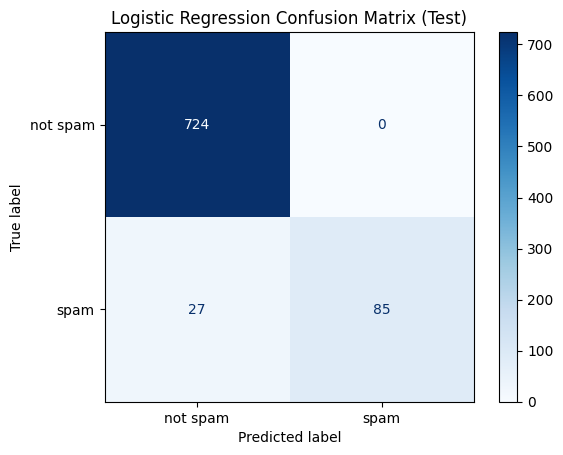

Multinomial Naive Bayes Test Accuracy: 0.9797
Multinomial Naive Bayes Confusion Matrix for Test Data:


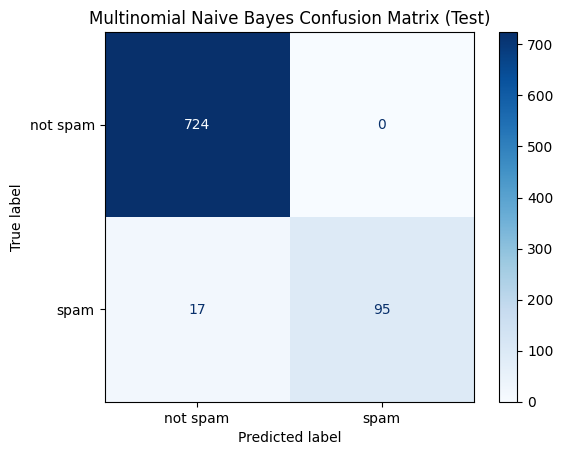

Support Vector Machine Test Accuracy: 0.9880
Support Vector Machine Confusion Matrix for Test Data:


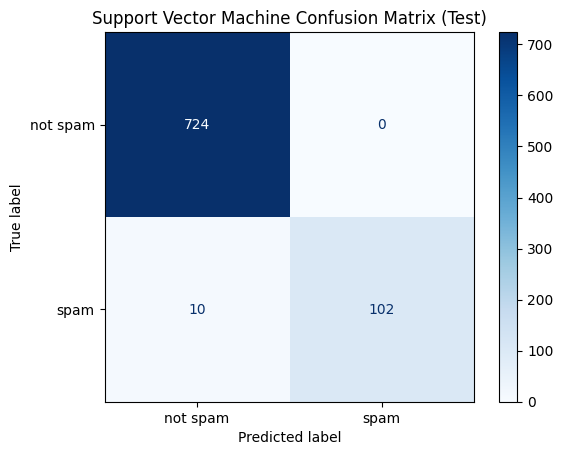

In [42]:
print("Benchmarking Models on Test Data")
models = {
    'Logistic Regression': logistic_model,
    'Multinomial Naive Bayes': nb_model,
    'Support Vector Machine': svm_model,
}

# Dictionary to store test accuracies for each model
test_accuracies = {}

for name, model in models.items():
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies[name] = accuracy
    print(f"{name} Test Accuracy: {accuracy:.4f}")

    # Plot confusion matrix for each model on test data
    print(f"{name} Confusion Matrix for Test Data:")
    cm = confusion_matrix(y_test, y_test_pred, labels=["not spam", "spam"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not spam", "spam"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} Confusion Matrix (Test)")
    plt.show()


In [43]:
# Add the best logistic model after fine-tuning to the dictionary
test_accuracies['Best Logistic Regression'] = test_accuracy

# Find the best model
best_model_name = max(test_accuracies, key=test_accuracies.get)
print(f"The best model is: {best_model_name} with Test Accuracy: {test_accuracies[best_model_name]:.4f}")


The best model is: Support Vector Machine with Test Accuracy: 0.9880
